In [1]:
import sys
sys.path.append("..")

import helper as hlp
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to C:\Users\Abdul
[nltk_data]     Manaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
EPOCHS = 50
MAX_LEN = 30
N_CLASSES = 2
BATCH_SIZE = 64
LEARNING_RATE = 2e-5
NAME = 'mBert(bert)-combined'
MODEL_NAME = 'bert-base-multilingual-uncased'

# dir = '/content/drive/MyDrive/Hate Speech_Multilingual /Code/Dataset Statistics/dataset'
dir = '../../../Dataset Statistics/dataset'

# path = f'/content/drive/MyDrive/Hate Speech_Multilingual /Code/Model training/saved_models/{NAME}'
path = f'../saved_models/{NAME}'

In [3]:
train_df = pd.read_csv(f'{dir}/train.csv')
val_df = pd.read_csv(f'{dir}/val.csv')
test_df = pd.read_csv(f'{dir}/test.csv')

english_train_texts = train_df['english_text'].values
english_val_texts = val_df['english_text'].values
english_test_texts = test_df['english_text'].values

english_train_labels = train_df['class'].values
english_val_labels = val_df['class'].values
english_test_labels = test_df['class'].values

urdu_train_texts = train_df['urdu_text'].values
urdu_val_texts = val_df['urdu_text'].values
urdu_test_texts = test_df['urdu_text'].values

urdu_train_labels = train_df['class'].values
urdu_val_labels = val_df['class'].values
urdu_test_labels = test_df['class'].values

sindhi_train_texts = train_df['sindhi_text'].values
sindhi_val_texts = val_df['sindhi_text'].values
sindhi_test_texts = test_df['sindhi_text'].values

sindhi_train_labels = train_df['class'].values
sindhi_val_labels = val_df['class'].values
sindhi_test_labels = test_df['class'].values

english_train_texts = [hlp.preprocess_text(text, language="english") for text in english_train_texts]
english_val_texts = [hlp.preprocess_text(text, language="english") for text in english_val_texts]
english_test_texts = [hlp.preprocess_text(text, language="english") for text in english_test_texts]

urdu_train_texts = [hlp.preprocess_text(text, language="urdu") for text in urdu_train_texts]
urdu_val_texts = [hlp.preprocess_text(text, language="urdu") for text in urdu_val_texts]
urdu_test_texts = [hlp.preprocess_text(text, language="urdu") for text in urdu_test_texts]

sindhi_train_texts = [hlp.preprocess_text(text, language="sindhi") for text in sindhi_train_texts]
sindhi_val_texts = [hlp.preprocess_text(text, language="sindhi") for text in sindhi_val_texts]
sindhi_test_texts = [hlp.preprocess_text(text, language="sindhi") for text in sindhi_test_texts]

# Concatenate text arrays
train_texts = np.concatenate([english_train_texts, urdu_train_texts, sindhi_train_texts])
val_texts = np.concatenate([english_val_texts, urdu_val_texts, sindhi_val_texts])
test_texts = np.concatenate([english_test_texts, urdu_test_texts, sindhi_test_texts])

# Concatenate label arrays
train_labels = np.concatenate([english_train_labels, urdu_train_labels, sindhi_train_labels])
val_labels = np.concatenate([english_val_labels, urdu_val_labels, sindhi_val_labels])
test_labels = np.concatenate([english_test_labels, urdu_test_labels, sindhi_test_labels])

In [4]:
#shuffle data
train_texts, train_labels = hlp.shuffle_data(train_texts, train_labels)
val_texts, val_labels = hlp.shuffle_data(val_texts, val_labels)
test_texts, test_labels = hlp.shuffle_data(test_texts, test_labels)

In [5]:
#show 5 values along with their labels
for i in range(5):
    print(train_texts[i], train_labels[i])

reallyvirtual میں سب کچھ نفرت کرتا 0
nomo cause gone new bitch highest 1
well guess fuck 0
بار میں نے مجھے سرنگ دیا کبھی نہیں کروں گا 1
اگر آپ کو لگتا آپ گھر میں سچی اکثریت کو ہونا چاہئے گھر میں وی بی بی سی حاصل کرنے لیے ٹی سی پی سی پی۔ 0


In [6]:
## mbert model and tokenizer
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=N_CLASSES)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
model.to(device)

c:\Users\Abdul Manaf\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\utils\_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [7]:
train_data_loader = hlp.create_data_loader(train_texts, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = hlp.create_data_loader(val_texts, val_labels, tokenizer, MAX_LEN, BATCH_SIZE)

history = hlp.train_model(train_data_loader, val_data_loader, model, optimizer, device, EPOCHS, tokenizer, path)

Epoch 1/50
----------


Training Progress: 100%|██████████| 3703/3703 [11:25<00:00,  5.40it/s, loss=0.191] 


Train loss 0.2785599993518195 accuracy 0.872885254064912
Validation loss 0.24641749511363537 accuracy 0.8894670211419167
Model and tokenizer saved at epoch 1
Checkpoint saved: Improved validation accuracy at epoch 1: 0.8894670211419167
Metrics logged at epoch 1
Epoch 2/50
----------


Training Progress: 100%|██████████| 3703/3703 [11:30<00:00,  5.37it/s, loss=0.141] 


Train loss 0.2275755559417434 accuracy 0.8983782552000912
Validation loss 0.23859207314035671 accuracy 0.8951892644638562
Model and tokenizer saved at epoch 2
Checkpoint saved: Improved validation accuracy at epoch 2: 0.8951892644638562
Metrics logged at epoch 2
Epoch 3/50
----------


Training Progress: 100%|██████████| 3703/3703 [11:27<00:00,  5.38it/s, loss=0.109] 


Train loss 0.1945357052335184 accuracy 0.9140893035739154
Validation loss 0.2522564991162373 accuracy 0.8902392707937714
No improvement in validation accuracy for 1 epochs.
Metrics logged at epoch 3
Epoch 4/50
----------


Training Progress: 100%|██████████| 3703/3703 [11:27<00:00,  5.38it/s, loss=0.0925]


Train loss 0.16466184224618502 accuracy 0.9281883131406483
Validation loss 0.28485308762805667 accuracy 0.8916698316242563
No improvement in validation accuracy for 2 epochs.
Metrics logged at epoch 4
Epoch 5/50
----------


Training Progress: 100%|██████████| 3703/3703 [11:28<00:00,  5.38it/s, loss=0.0666]


Train loss 0.13788800638233437 accuracy 0.9418273430477662
Validation loss 0.3122818370066915 accuracy 0.8892897835169009
No improvement in validation accuracy for 3 epochs.
Metrics logged at epoch 5
Epoch 6/50
----------


Training Progress: 100%|██████████| 3703/3703 [11:28<00:00,  5.38it/s, loss=0.0513]


Train loss 0.11713972837064851 accuracy 0.9520777154624906
Validation loss 0.3496992783688823 accuracy 0.8882263577668059
No improvement in validation accuracy for 4 epochs.
Metrics logged at epoch 6
Epoch 7/50
----------


Training Progress: 100%|██████████| 3703/3703 [11:28<00:00,  5.38it/s, loss=0.0385] 


Train loss 0.09818257448418645 accuracy 0.9602265294323683
Validation loss 0.3860742204856535 accuracy 0.8852512976326117
No improvement in validation accuracy for 5 epochs.
Stopping early due to lack of improvement in validation accuracy.


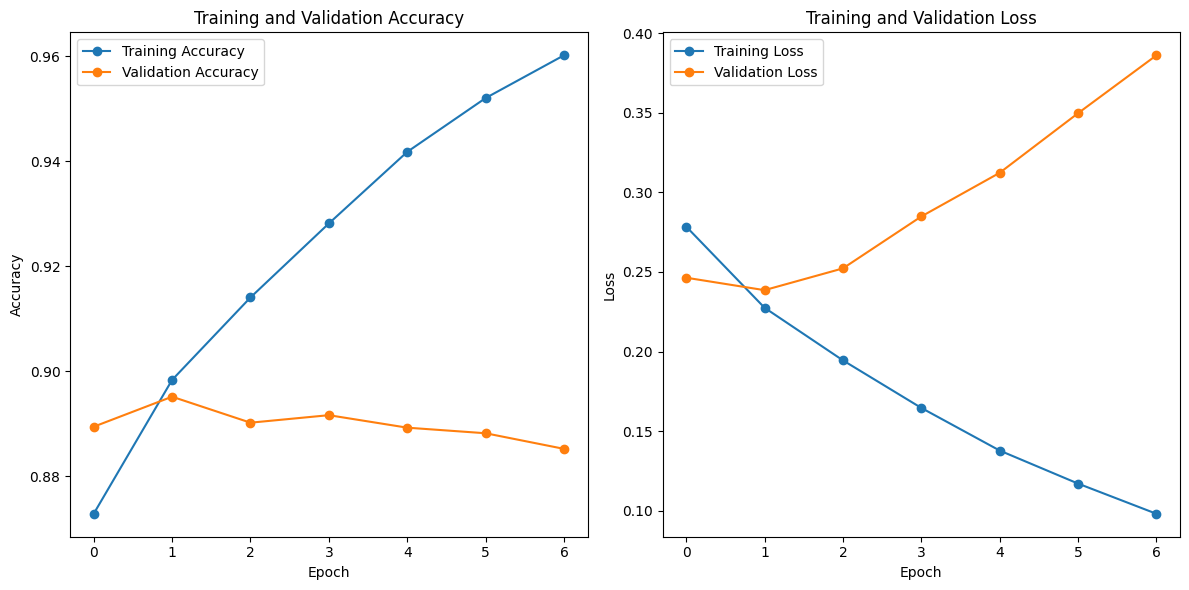

In [8]:
hlp.plot_history(history)

In [9]:
test_data_loader = hlp.create_data_loader(test_texts, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)

test_acc, test_loss, test_label_actual, test_label_pred = hlp.eval_model(model, test_data_loader, device)

print(f'Test Accuracy: {test_acc} Test Loss: {test_loss}')

Test Accuracy: 0.8836814786681858 Test Loss: 0.38671627475725495


Classification Report:
              precision    recall  f1-score   support

    Non-Hate       0.91      0.90      0.91     48898
        Hate       0.84      0.86      0.85     30092

    accuracy                           0.88     78990
   macro avg       0.88      0.88      0.88     78990
weighted avg       0.88      0.88      0.88     78990



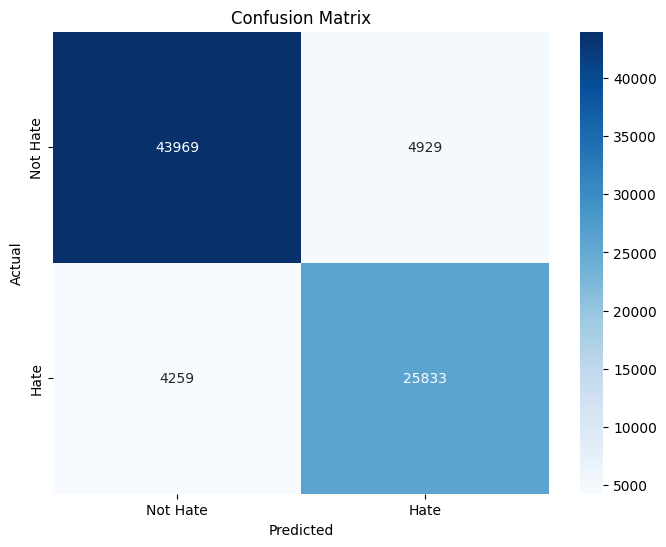

In [10]:
hlp.plot_confusion_matrix(test_label_actual, test_label_pred, ['Non-Hate', 'Hate'])

In [11]:
test_texts = ["This is the sort of thing that happens in a shithole country. @URL"]
preds, confidence = hlp.predict(test_texts, model, tokenizer, MAX_LEN, device)

if preds[0] == 1:
    print(f'Predicted class: Hate Speech \nConfidence: {confidence[0][1]:.2f}')
else:
    print(f'Predicted class: Not Hate Speech \nConfidence: {confidence[0][0]:.2f}')

Predicted class: Hate Speech 
Confidence: 0.98
